<a href="https://colab.research.google.com/github/AnIsAsPe/ClassificadorCancerEsofago/blob/master/Notebooks/PerceptronClasificadorCancerEs%C3%B3fago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Clasificador de tejido sano y tejido cancerígeno en imágenes microscópicas del esófago

![image.png](https://drive.google.com/uc?id=1K_j4CnOJeOmiROBiFwEW1M-kJkizrMk7)

## Paso 1. Cargar librerías y módulos requerdidos

In [2]:
import random        # Módulo para aleatorizar.
import pickle        # Módulo para respaldar objetos de pyhton como cadenas de bytes
                     # (serialización de objetos).

import numpy as np   # Biblioteca para manejar matrices y operaciones de matrices
import pandas as pd  # Biblioteca para manejar tablas de datos.

# Funciones de la biblioteca Scikit-image para leer y mostrar una una imagen.
from skimage.io import imread

# Sklearn (Scikit-learn) es la  principal biblioteca para machine learning.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron

# Bibliotecas para gráficar y visualizar.
import matplotlib.pyplot as plt
import seaborn as sns

## Paso 2. Lectura de datos.

### 2.1 Lectura de etiquetas (y)

In [3]:
# Leemos los datos.

datos = pd.read_csv("https://raw.githubusercontent.com/AnIsAsPe/ClassificadorCancerEsofago/master/Datos/ClasesImagenes.csv", usecols=[1,2])


In [4]:
print(type(datos))

<class 'pandas.core.frame.DataFrame'>


In [5]:
 # Muestra los primeros cinco registros.
datos.head()

,image_filename,class_number
0,im_4_0.png,0
1,im_21_0.png,0
2,im_9_0.png,0
3,im_8_0.png,0
4,im_15_0.png,0


In [6]:
# ¿Con cuántas imagenes vamos a trabajar?

len(datos)

5063

In [7]:
# ¿cuántas imagenes tenemos de cada clase?

datos['class_number'].value_counts(sort=False)

,count
class_number,
0,1469
1,3594


Clase 0 corresponde a tejido sano y Clase 1 a tejido Cancerígeno

In [8]:
# Guardamos las etiquetas de las imagenes como Series de Pandas.
y = datos['class_number']


### 2.2 Lectura de imágenes (X)

**Lo primero que tenemos que hacer es descomprimir el archivo zip que guardamos en nuestro dirve**

In [ ]:

!unzip -u "/content/drive/MyDrive/Datos/DatosCancer/imagenes_260x260.zip" -d "/content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/"


Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_3.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_31.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_34.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_36.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_4.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_40.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_42.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_44.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_49.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_50.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_53.png  
  inflating: /content/

**Vamos a leer la primera imagen, para ello además del nombre de la imagen, necesitamos añadir la ruta del directorio en donde se encuentra dicha imagen.**

In [9]:
nombre_archivo = 'im_4_0.png'

ruta = '/content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/'

imagen = imread(ruta  + nombre_archivo)

In [10]:
# ¿Qué tipo de objeto es imagen?
type(imagen)

numpy.ndarray

In [11]:
# ¿Qué dimensiones tiene imagen?

imagen.shape  # tupla de renglones y columnas

(260, 260)

In [12]:
# Exploramos el nivel de coloración de algunos de los pixeles de la imagen
imagen[52:68, 170:179]

array([[ 54,  52,  49,  47,  43,  39,  38,  38,  37],
       [ 79,  75,  73,  72,  69,  64,  63,  64,  62],
       [123, 115, 108, 103,  99,  94,  91,  93,  91],
       [165, 154, 141, 129, 122, 120, 123, 128, 126],
       [212, 207, 198, 187, 178, 179, 183, 186, 178],
       [250, 251, 249, 244, 239, 236, 237, 235, 226],
       [253, 254, 253, 251, 250, 250, 251, 252, 249],
       [247, 248, 250, 251, 246, 241, 245, 249, 251],
       [235, 238, 242, 245, 244, 242, 245, 248, 252],
       [222, 227, 233, 237, 241, 246, 245, 245, 249],
       [203, 207, 215, 226, 233, 233, 231, 233, 239],
       [163, 167, 178, 189, 195, 197, 204, 211, 219],
       [115, 120, 129, 137, 140, 145, 159, 172, 182],
       [ 95,  99, 103, 103, 102, 104, 116, 125, 134],
       [ 85,  87,  88,  87,  86,  88,  93,  95,  99],
       [ 79,  79,  81,  82,  84,  84,  85,  85,  86]], dtype=uint8)

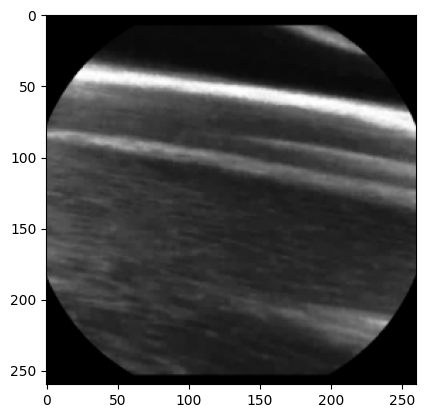

In [13]:
_ = plt.imshow(imagen, cmap='Greys_r' )

**Ahora vamos a hacer lo mismo para todas las imagenes**

In [ ]:
%time  img = datos['image_filename'].apply(lambda x: imread(ruta + x))

CPU times: user 15.9 s, sys: 2.43 s, total: 18.3 s
Wall time: 41.1 s


<h2>Respaldamos el objeto img en un archivo pickle.<h2>

(si quieres conocer más sobre pickles de python, revisa [este enlace](https://programacion.net/articulo/los_pickles_de_python_1860))

In [ ]:
# # Guardar en archivo pickle
# ruta2 = '/content/drive/MyDrive/Datos/DatosCancer/' # directorio donde se guardará el
# pickle.dump(img, open (ruta2 + "imagenes_numpy.pkl", 'wb'))

In [14]:
# Leer archivo pickle
ruta2 = '/content/drive/MyDrive/Datos/DatosCancer/'
img = pickle.load(open(ruta2 + "imagenes_numpy.pkl", 'rb'))

In [15]:
img[47].shape

(260, 260)

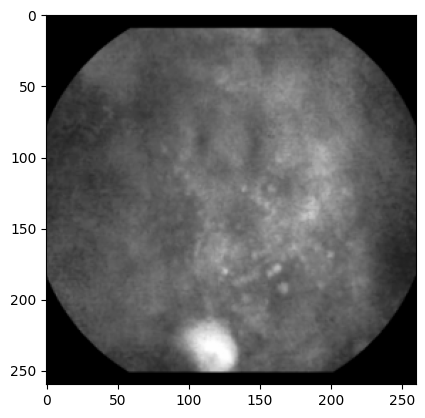

In [16]:
_ = plt.imshow(img[47],  cmap='Greys_r')

- Dimensión 0: 260 renglones de pixeles de arriba a abajo
- Dimensión 1: 260 columnas de pixeles de izquierda a derecha


####  Transformar imágenes en vectores

In [ ]:
# Una serie de pandas es también una secuencia (como lo son las listas,
# las tuplas, las cadenas de caracteres o los vectores de numpy).

print(type(img))

<class 'pandas.core.series.Series'>


In [ ]:
# Cantidad de elementos en la serie
img.shape

(5063,)

In [17]:
# Cada elemento de mi secuencia es una matriz de 260 x 260
img[3673].shape

(260, 260)

Lo primero es transformar la secuencia de matrices img en una sola matriz

In [18]:
IMG = np.stack(img, axis=0)   # Toma una secuencia de matrices y las apila a lo largo
                              # de un tercer eje para hacer una solo arreglo
IMG.shape

(5063, 260, 260)

Despues aplanar la matriz de 2D (260x260 pixeles) de cada imagen, para obtener un vector por imagen.

In [19]:
X = IMG.reshape(5063, 67600)
X.shape

(5063, 67600)

##### Visualizamos ejemplos de ambas clases de imagenes

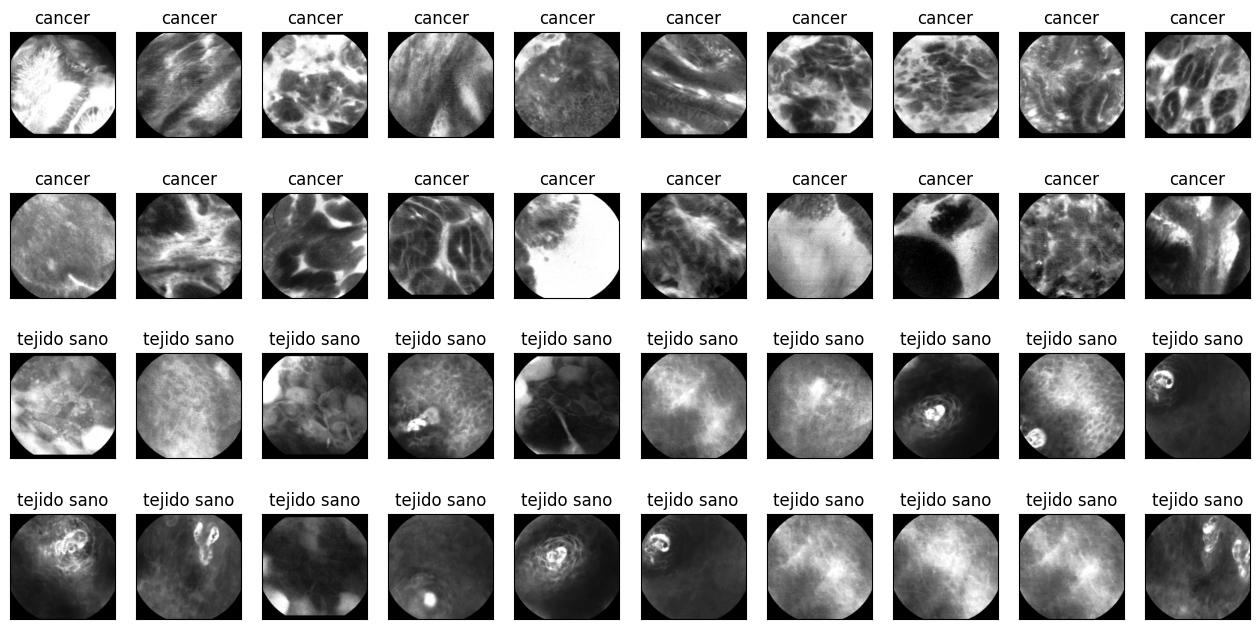

In [27]:
# Con el método GroupBy de Pandas separamos el data frame en dos, de acuerdo
# la nuestra etiqueta.
porClase = datos.groupby('class_number')

# Elijimos al azar n muestras de cada subconjunto y guardamos la posición de las
# imagenes cancerigenas en la lista "c" y en  "s" las de tejido sano.
n = 20
c = random.sample(porClase.get_group(1).index.tolist(), n)
s = random.sample(porClase.get_group(0).index.tolist(), n)


# Creamos el espacio para las 40 imagenes que vamos a desplegar
fig = plt.figure(figsize=(16, 8))
columns = 10
rows = 4

# Desplegamos las imagenes
for i in range(0, 40):
    fig.add_subplot( rows, columns, i+1)
    if i < 20:
        plt.imshow(img[c[i]],cmap='Greys_r')
        plt.title('cancer')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow(img[s[i-20]], cmap='Greys_r')
        plt.title('tejido sano')
        plt.xticks([])
        plt.yticks([])
plt.show()

## Paso 3. Construcción de nuestro clasificador

### 3.1  Crear subconjuntos de entrenamiento y prueba



In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    shuffle=True,  # Muy importante
    stratify=y,
    random_state=5
)

In [21]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de Entrenamiento")
print(f"X: {X_train.shape}")
print(f"y: {y_train.shape}")
print(f"Proporción de imágenes cancerígenas: {y_train.mean():.3f}\n")

print("Conjunto de Prueba")
print(f"X: {X_test.shape}")
print(f"y: {y_test.shape}")
print(f"Proporción de imágenes cancerígenas: {y_test.mean():.3f}")

Conjunto de Entrenamiento
X: (3544, 67600)
y: (3544,)
Proporción de imágenes cancerígenas: 0.710

Conjunto de Prueba
X: (1519, 67600)
y: (1519,)
Proporción de imágenes cancerígenas: 0.710


### 3.2  Entrenamiento



In [22]:
model = Perceptron(max_iter=1000, random_state=0, verbose=False)
model.fit(X_train, y_train)

print("Iterations: ", model.n_iter_)

Iterations:  57


In [ ]:
# Guardamos los coeficientes del modelo
betas = model.coef_
betas.shape

(1, 67600)

In [ ]:
beta0 = model.intercept_
beta0

array([-720.])

In [ ]:
betas[0, 50310:50320]

array([-6260.,  4608., 14775., 19668., 14126., 10948.,  6639.,  3357.,
        3500.,  5002.])

### 3.3 Pedicción

In [23]:
y_predict = model.predict(X_test)  # Predice la etiqueta de cada imagen en X_test
y_predict[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1])

### 3.4 Evaluación

In [24]:
y_test.to_numpy()[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1])

In [25]:
print(f"Exactitud: {(y_test == y_predict).mean():.4f}")

Exactitud: 0.9302


Además de evaluar el desempeño en el conjunto de prueba, es muy importante comparar el error en el entrenamiento contra el error de generalización.
Con estas dós métricas podemos darnos cuenta de si el modelo  está logrando aprender los patrones que presentan los datos y si es capaz de generalizar ese resultado.

In [ ]:
# Es muy importante comparar el error en el entrenamiento contra el error de generalización
print(f"Exactitud conjunto entrenamiento: {model.score(X_train, y_train):.4f}")
print(f"Exactitud conjunto prueba: {model.score(X_test, y_test):.4f}")

Exactitud conjunto entrenamiento: 0.9901
Exactitud conjunto prueba: 0.9302


Mas allá de conocer qué tanto se equivoca el clasificador en imagenes nuevas, es importante distinguir la naturaleza de esos errores. Para ello nos servimos de la "Matriz de confusión"


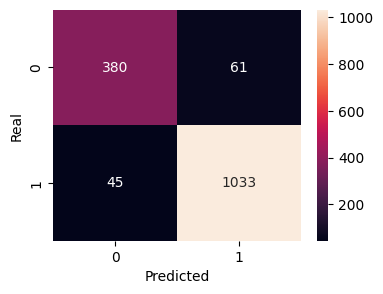

In [ ]:
def matriz_confusion(y_test, y_predict):
    df = pd.DataFrame({
        'Real': y_test,
        'Predicted': y_predict
    })
    # Matriz de confusión
    confusion_matrix = pd.crosstab(df['Real'],df['Predicted']
                               )
    fig, ax = plt.subplots(figsize=(4, 3))  # Tamaño de la figura
    _ = sns.heatmap(confusion_matrix, annot=True, fmt='g',  ax=ax)

matriz_confusion(y_test, y_predict)

## Paso 4. Entrenamiento de perceptron utilizando margen

In [ ]:
model_2 = Perceptron(max_iter=1000,  random_state=0, verbose=False,
                    penalty='l2', alpha=7e-9)
model_2.fit(X_train,y_train)

print("Exactitud conjunto entrenamiento: %.2f%%" % (model_2.score(  X_train, y_train)*100.0))
print("Exactitud conjunto prueba: %.2f%%" % (model_2.score(X_test, y_test)*100.0))

Exactitud conjunto entrenamiento: 98.65%
Exactitud conjunto prueba: 93.15%


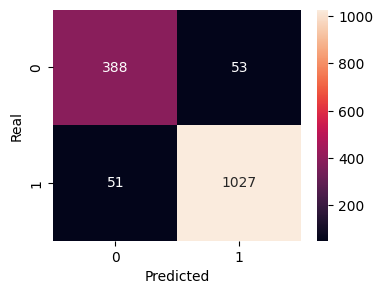

In [ ]:
y_predict_2 = model_2.predict(X_test)
matriz_confusion(y_test, y_predict_2)